In [101]:
from src.utils.env_export import create_json
from src.utils.khalili_env import get_env
from src.policy.jas_voc_policy import JAS_voc_policy
from src.utils.mouselab_jas import MouselabJas
import numpy as np
import random
import seaborn as sns
from matplotlib import pyplot as plt
import json

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
cost_weight= 0.5798921379230035

for size in range(2, 6):
    env, config = get_env(size)
    create_json(f"./data/khalili_env_{size}.json", config, list(range(1, 31)), cost_weight=cost_weight)

In [90]:
def select_n(x, n):
    n = min(n, len(x))
    sampled_indices = np.random.choice(a=len(x), size=n, replace=False)
    return [x[i] for i in sampled_indices]

def get_highlight(env: MouselabJas, policy: JAS_voc_policy, num_choices: int, tolerance=0.001, mode="random"):

    actions, vocs = policy.get_all_vocs(env)
    max_voc = np.max(vocs)

    # Remove term actions
    assert actions[-1]==env.term_action
    actions = actions[:-1]
    vocs = vocs[:-1]
    
    # Split actions in optimal and suboptimal actions
    optimal = []
    suboptimal = []
    for action, voc in zip(actions, vocs):
        if np.abs(max_voc - voc) <= tolerance:
            optimal.append(action)
        else:
            suboptimal.append(action)
    
    # Prefer actions with a low project in case of ties
    lowest_project = env.num_projects
    lowest_project_actions = []
    for action in optimal:
        project = env.action_to_readable(action)[0]
        lowest_project = min(lowest_project, project)
    for action in optimal:
        project = env.action_to_readable(action)[0]
        if project == lowest_project:
            lowest_project_actions.append(action)

    # Generate highlights
    highlights = []
    if max_voc == 0:
        choice = env.term_action
        #highlights.append(env.action_to_readable(env.term_action))
        highlights.extend([env.action_to_readable(action) for action in select_n(suboptimal, num_choices)])
    else:
        choice = random.choice(lowest_project_actions)
        choice_readable = env.action_to_readable(choice)
        highlights.append(choice_readable)
        num_remaining = num_choices - 1
        # Alternate choice preference order
        perfect_match_suboptimal = []
        ok_match_suboptimal = []
        bad_match_suboptimal = []

        if mode == "random":
            perfect_match_suboptimal = suboptimal
        elif mode == "criteria":
            for action in suboptimal:
                action_readable = env.action_to_readable(action)
                if (action_readable[0] == choice_readable[0]) and (action_readable[1] == choice_readable[1]):
                    perfect_match_suboptimal.append(action)
                elif (action_readable[1] == choice_readable[1]):
                    ok_match_suboptimal.append(action)
                else:
                    bad_match_suboptimal.append(action)
        elif mode == "expert":
            for action in suboptimal:
                action_readable = env.action_to_readable(action)
                if (action_readable[0] == choice_readable[0]) and (action_readable[2] == choice_readable[2]):
                    perfect_match_suboptimal.append(action)
                elif (action_readable[2] == choice_readable[2]):
                    ok_match_suboptimal.append(action)
                else:
                    bad_match_suboptimal.append(action)
        elif mode == "project":
            for action in suboptimal:
                action_readable = env.action_to_readable(action)
                if (action_readable[1] == choice_readable[1]) and (action_readable[2] == choice_readable[2]):
                    perfect_match_suboptimal.append(action)
                elif (action_readable[1] == choice_readable[1]) or (action_readable[2] == choice_readable[2]):
                    ok_match_suboptimal.append(action)
                else:
                    bad_match_suboptimal.append(action)
        else:
            assert 0, "unknown mode: "+mode
        
        if num_remaining > 0:
            highlights.extend([env.action_to_readable(a) for a in select_n(perfect_match_suboptimal, num_remaining)])
            num_remaining = num_remaining - min(len(perfect_match_suboptimal), num_remaining)
        if num_remaining > 0:
            highlights.extend([env.action_to_readable(a) for a in select_n(ok_match_suboptimal, num_remaining)])
            num_remaining = num_remaining - min(len(ok_match_suboptimal), num_remaining)
        if num_remaining > 0:
            highlights.extend([env.action_to_readable(a) for a in select_n(bad_match_suboptimal, num_remaining)])
            num_remaining = num_remaining - min(len(bad_match_suboptimal), num_remaining)

    return highlights, choice

def get_highlights(n: int, num_projects: int, num_choices: int, mode="random"):
    env, config = get_env(num_projects)
    policy = JAS_voc_policy(discrete_observations=True, cost_weight=cost_weight)

    highlights = []
    for i in range(n):
        env.reset()
        done = False
        while not done:
            highlight, choice = get_highlight(env, policy, num_choices, mode=mode)
            #print(highlight, choice)
            highlights.extend(highlight)
            _, _, done, _ = env.step(choice)
    return highlights

In [96]:
def plot(projects, criteria, experts):
    fig, axes =plt.subplots(1,3, figsize=(15,4))
    axes = axes.flatten()

    g = sns.histplot(projects, discrete=True, shrink=0.9, stat="probability", ax=axes[0])
    g.set_title("Project distribution")
    g.set_xlabel("Project")
    g.set_ylabel("Probability")

    g = sns.histplot(criteria, discrete=True, shrink=0.9, stat="probability", ax=axes[1])
    g.set_title("Criteria distribution")
    g.set_xlabel("Criteria")
    g.set_ylabel("Probability")

    g = sns.histplot(experts, discrete=True, shrink=0.9, stat="probability", ax=axes[2])
    g.set_title("Expert distribution")
    g.set_xlabel("Expert")
    g.set_ylabel("Probability")

    plt.show()

def get_distribution(x):
    num_elements = len(x)
    counter = [0 for _ in range(max(x)+1)]
    for element in x:
        counter[element] += 1
    return [element/num_elements for element in counter]

def gen_distribution_data(num_projects, num_choices, n=100):
    highlights = []
    highlights.extend(get_highlights(n=n, num_projects=num_projects, num_choices=num_choices, mode="criteria"))
    highlights.extend(get_highlights(n=n, num_projects=num_projects, num_choices=num_choices, mode="expert"))
    highlights.extend(get_highlights(n=n, num_projects=num_projects, num_choices=num_choices, mode="project"))

    projects = [x[0] for x in highlights]
    criteria = [x[1] for x in highlights]
    experts = [x[2] for x in highlights]

    project_dist = get_distribution(projects)
    criteria_dist = get_distribution(criteria)
    expert_dist = get_distribution(experts)

    print("Projects:", project_dist)
    print("Criteria:", criteria_dist)
    print("Experts:", expert_dist)
    plot(projects, criteria, experts)
    
    res = {
        "num_projects": num_projects,
        "num_choices": num_choices,
        "project_dist": project_dist,
        "criteria_dist": criteria_dist,
        "expert_dist": expert_dist
    }

    return res

Projects: [0.5561085972850679, 0.4438914027149321]
Criteria: [0.06923076923076923, 0.0755656108597285, 0.10045248868778281, 0.07375565610859729, 0.6076923076923076, 0.07330316742081448]
Experts: [0.09683257918552036, 0.3072398190045249, 0.09276018099547512, 0.08597285067873303, 0.12171945701357466, 0.29547511312217195]


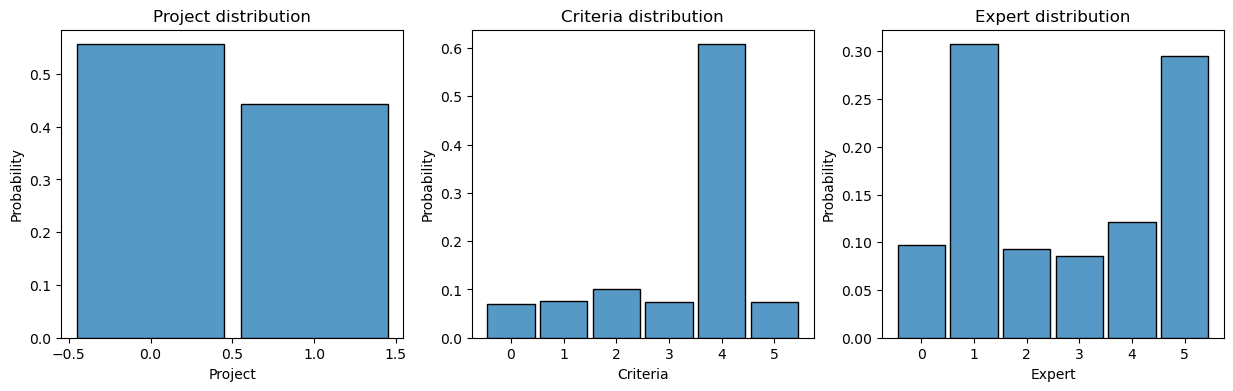

In [97]:
# Level 1: 2 projects, 2 choices
env22 = gen_distribution_data(2, 2)

Projects: [0.39600920951650037, 0.3323100537221796, 0.27168073676132004]
Criteria: [0.07649015093374265, 0.07725761064210795, 0.07776925044768483, 0.07597851112816577, 0.6149910463034024, 0.07751343054489639]
Experts: [0.0892811460731645, 0.30033256587362495, 0.11025837810181632, 0.09542082374008698, 0.10949091839345101, 0.29521616781785626]


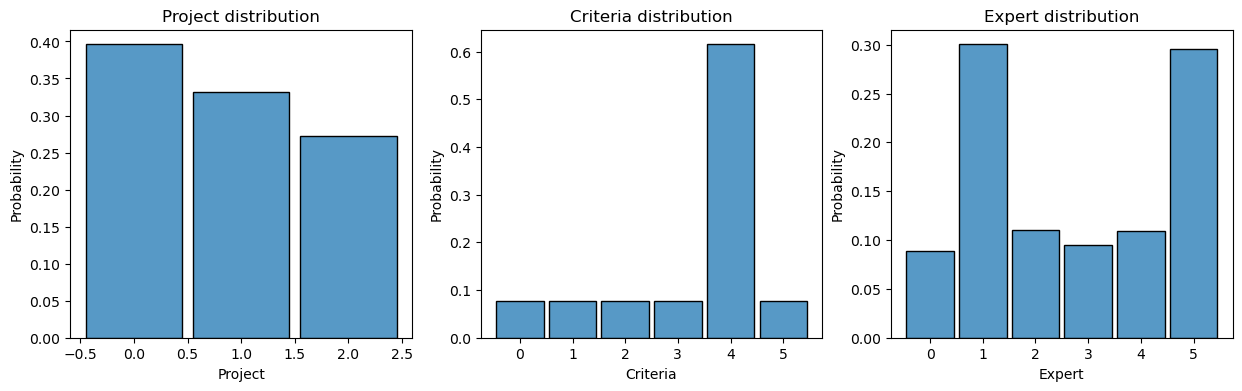

In [98]:
# Level 2: 3 projects, 3 choices
env33 = gen_distribution_data(3, 3)

Projects: [0.3195571955719557, 0.2791512915129151, 0.22361623616236162, 0.17767527675276754]
Criteria: [0.07380073800738007, 0.07749077490774908, 0.07988929889298893, 0.07490774907749077, 0.6190036900369004, 0.07490774907749077]
Experts: [0.09372693726937269, 0.30018450184501844, 0.11180811808118081, 0.09649446494464944, 0.12380073800738008, 0.27398523985239853]


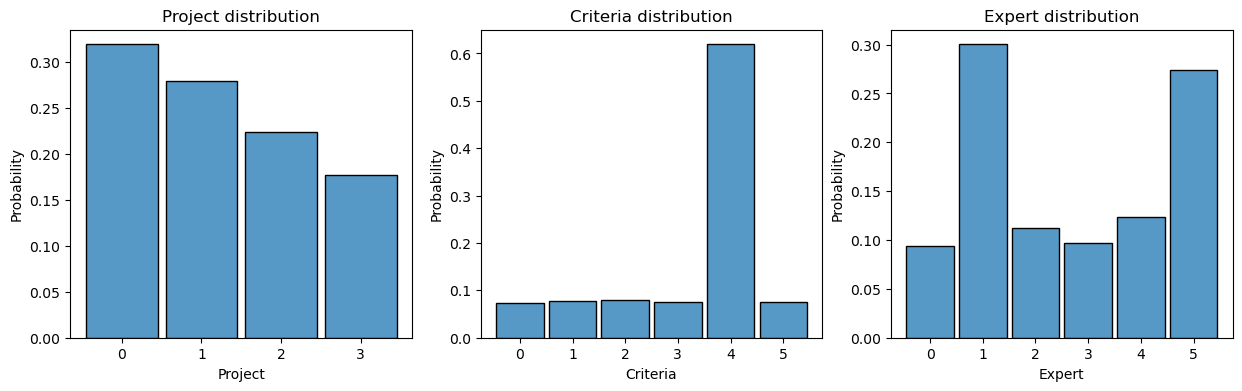

In [99]:
# Level 2.5: 4 projects, 4 choices
env44 = gen_distribution_data(4, 4)

Projects: [0.2848439821693908, 0.24918276374442794, 0.2086181277860327, 0.1512630014858841, 0.10609212481426449]
Criteria: [0.0811292719167905, 0.07934621099554234, 0.08365527488855869, 0.08276374442793462, 0.5860326894502229, 0.08707280832095096]
Experts: [0.09465081723625557, 0.3028231797919762, 0.1050520059435364, 0.09777117384843982, 0.12674591381872213, 0.2729569093610698]


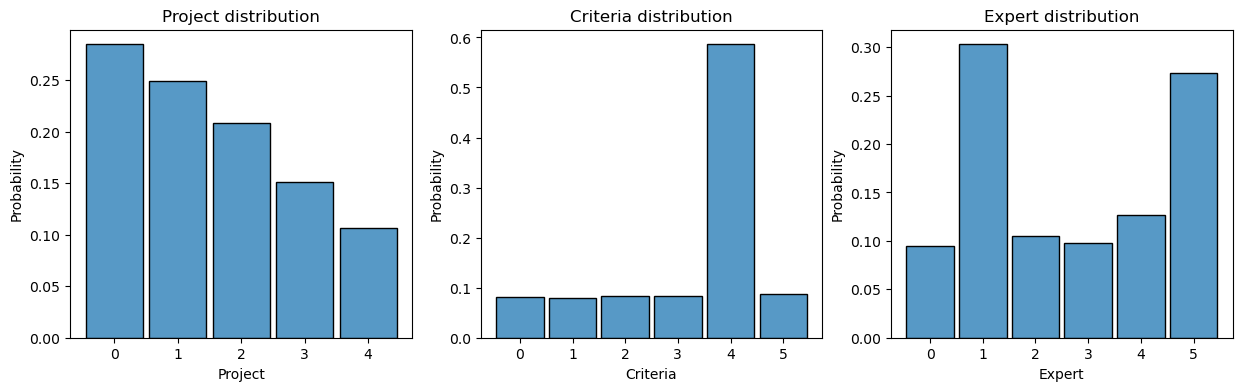

In [100]:
# Level 3: 5 projects, 5 choices
env55 = gen_distribution_data(5, 5)

In [103]:
distribution_data = {
    "env22": env22,
    "env33": env33,
    "env44": env44,
    "env55": env55
}

path = "./data/tutor_distribution.json"

with open(path, "w") as f:
    d = json.dumps(distribution_data)
    f.write(d)